# Classical AB testing

In [76]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn import preprocessing
from itertools import islice
from scipy.stats import norm
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings(action="ignore")
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from statsmodels.stats.proportion import proportions_ztest

 Load Data

In [9]:
df = pd.read_csv("../data/AdSmartABdata.csv")
df_control= pd.read_csv("../data/control_df.csv")
df_exposed= pd.read_csv("../data/exposed_df.csv")

In [3]:
df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


Users that did not respond

In [4]:
drop_df= df.query('yes==0 and no==0')
df=df.drop(drop_df.index)


Users awareof the
 brand for both experiment groups

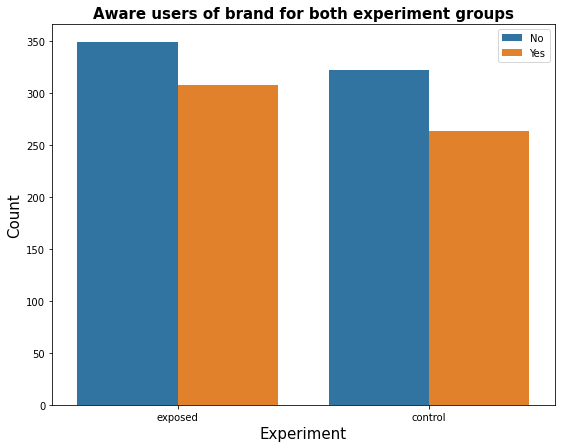

In [5]:
plt.figure(figsize=(9,7))
ax=sns.countplot(x ='experiment', hue='yes', data = df) 

ax.set_xlabel('Experiment', fontsize=15)
ax.set_ylabel('Count' , fontsize=15)
ax.set_title('Aware users of brand for both experiment groups', fontsize=15, fontweight='bold')
plt.legend( ['No', 'Yes'])



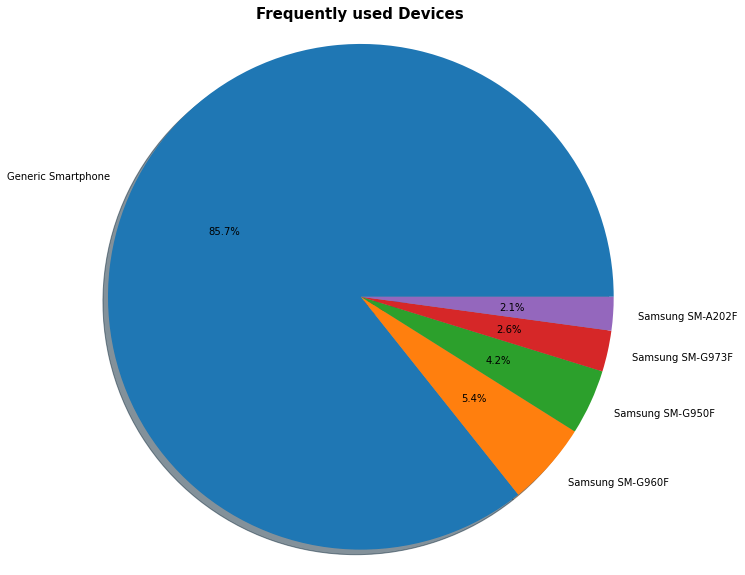

In [7]:
top_device= df['device_make'].value_counts().nlargest(5)
fig1, ax1 = plt.subplots(figsize = (10, 10))
ax1.pie(top_device.values, labels=top_device.index, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')

ax1.set_title('Frequently used Devices', fontsize=15, fontweight='bold')
plt.show()

Above figure shows the most frequent device types, it shows that 85.7% of the recorded data were from an unkonwn device

# Hypothesis Testing

## Stating the Hypothesis

We want to see if there is a performance difference between the two groups. 
We're especially interested in seeing if there's a statistically significant difference in their Engagement results.


${EngagementResult} = \tfrac{\text{Number of Yes}}{\text{Total number of events}}$

Let
<br/>
<br/>
Hypothesis 0 : $Control Group Engagement Result = Exposed Group Engagement Result$
<br/>
Hypothesis 1 : $Control Group Engagement Result \neq Exposed Group Engagement Result$


Level of Significance, $\alpha = 0.05$.

In [17]:
df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [18]:
# copying dataframe
response = df.copy(deep=True)

In [19]:
# getting users who only selects yes or no
response = response[response['yes'] == 1].append(response[response['no'] == 1])
response.head(5)

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
16,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1,0
23,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1,0
45,018af862-486e-4da1-a85b-71872120e57c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,1,0
65,023ec7b5-cb8f-49a5-995f-e0d7c2f702e5,exposed,2020-07-09,13,Samsung SM-G935F,6,Facebook,1,0
89,02efdb70-8596-4f3f-b0b2-b91e194f61f7,exposed,2020-07-05,6,Generic Smartphone,6,Chrome Mobile,1,0


In [20]:
# finding the control group
control_df = response[response['experiment'] == 'control']
control_df.head(5)

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
23,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1,0
45,018af862-486e-4da1-a85b-71872120e57c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,1,0
100,0332a7f7-0336-4d48-96ad-75da00d916c0,control,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1,0
118,03948b84-b5b1-4f26-81fc-e953218aef1a,control,2020-07-09,20,Samsung SM-G930F,6,Facebook,1,0
157,04b69bd8-4849-4489-adcf-08b96a265c40,control,2020-07-07,15,Generic Smartphone,6,Chrome Mobile,1,0


In [21]:
# finding the exposed group
exposed_df = response[response['experiment'] == 'exposed']
exposed_df.head(5)

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
16,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1,0
65,023ec7b5-cb8f-49a5-995f-e0d7c2f702e5,exposed,2020-07-09,13,Samsung SM-G935F,6,Facebook,1,0
89,02efdb70-8596-4f3f-b0b2-b91e194f61f7,exposed,2020-07-05,6,Generic Smartphone,6,Chrome Mobile,1,0
128,03ee1780-1fa3-4bec-926c-d543a81a6653,exposed,2020-07-04,11,Samsung SM-G981B,6,Chrome Mobile WebView,1,0
144,046644f4-b30c-48f9-b069-f804a97b77d9,exposed,2020-07-05,2,Generic Smartphone,6,Chrome Mobile WebView,1,0


In [32]:
exposed_dff=(exposed_df.groupby('date').agg(yes=('yes','sum'),no=('no','sum')).reset_index())

In [33]:
control_dff=(control_df.groupby('date').agg(yes=('yes','sum'),no=('no','sum')).reset_index())

In [34]:
#Subsetting
exposed = exposed_dff[['yes','no']]
control = control_dff[['yes','no']]

In [41]:
# Calculate the engagement for the Exposed group
exposed['engagement'] = exposed['yes'] / (exposed['no'] + exposed['yes'])

In [45]:
# exposed engagement result
exposed.head()

,yes,no,engagement
0,43,49,0.467391
1,46,45,0.505495
2,35,39,0.472973
3,23,25,0.479167
4,22,24,0.478261


In [46]:
# Calculate the engagement for the Control group
control['engagement'] = control['yes'] / (control['no'] + control['yes'])

In [47]:
# control engagement result
control.head()

,yes,no,engagement
0,104,129,0.446352
1,30,38,0.441176
2,17,26,0.395349
3,12,14,0.461538
4,16,21,0.432432


In [51]:
#Adding scripts path
import sys
sys.path.insert(0,'../scripts/')
from data_preProcess import data_preProcess
from data_info import dataframeInfo 
from data_visualization import exploration

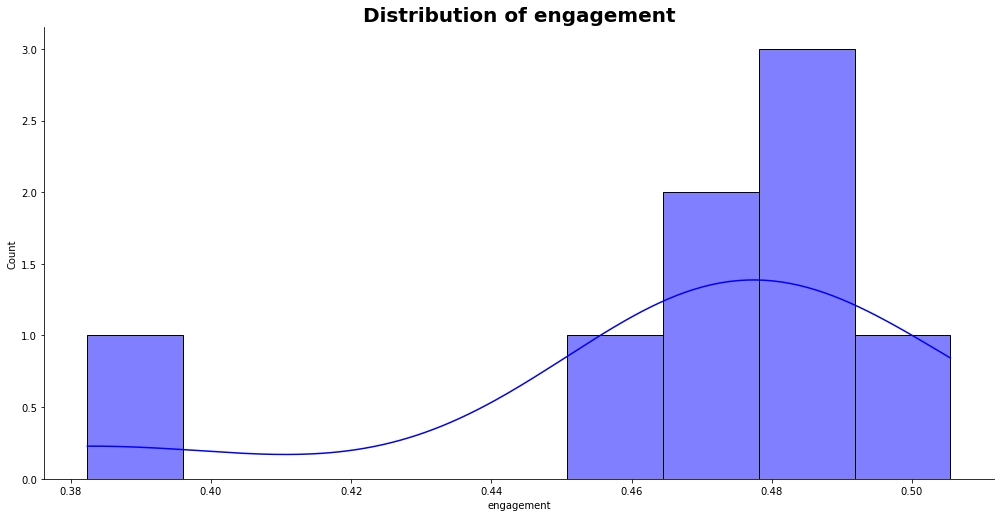

In [52]:
# exposed engagement rate
exploration.plot_hist(exposed, 'engagement', 'blue')

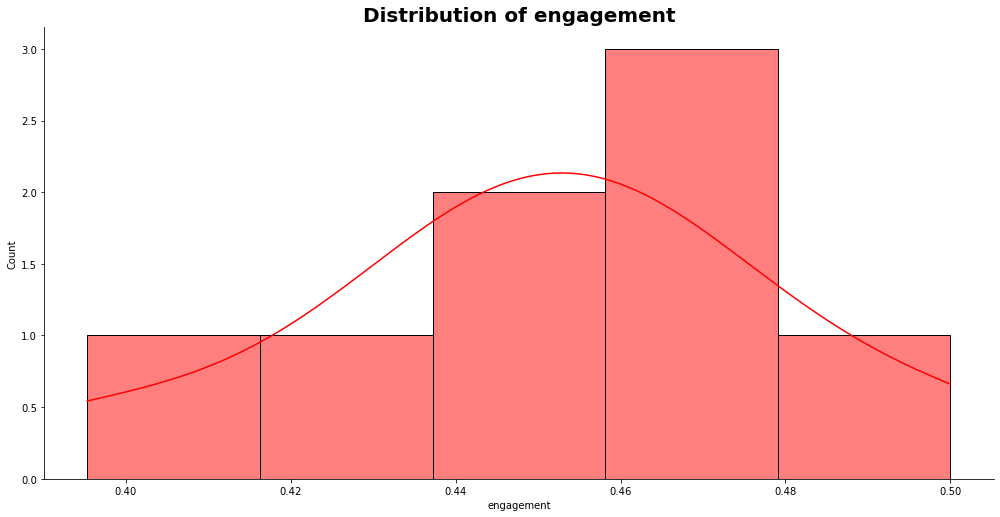

In [53]:
# control engagement rate
exploration.plot_hist(control, 'engagement', 'red')

In [64]:
# proportions
def test(group1, group2):
    n1 = (group1['no'].sum() + group1['yes'].sum())
    p1 = group1['yes'].sum() / float(n1)
    # 
    n2 = (group2['no'].sum() + group2['yes'].sum())
    p2 = group2['yes'].sum()  / float(n2)
    # 
    d= p2 - p1
    print(p1, p2, d)
test(group1=control, group2=exposed)

0.45051194539249145 0.4687975646879756 0.018285619295484168


In [65]:
# Standard Deviation, Standard errors 
def test2(group1, group2):
#     
    n1 = (group1['no'].sum() + group1['yes'].sum())
    n2 = (group2['no'].sum() + group2['yes'].sum())
#     
    p_overall = (group1['yes'].sum() + group2['yes'].sum() )/ (n1+n2)
#    
    se1 = (p_overall * (1 - p_overall))/n1
#     
    se2 = (p_overall * (1- p_overall))/n2
#     
    standardError = np.sqrt(float(se1) + float(se2))
#     
    print('SE 1:', standardError)
test2(group1=control, group2=exposed)

SE 1: 0.028319932727228023


In [75]:
# t-calculation
import scipy.stats
def test3(group1, group2):
    standardError = 0.028319932727228023
    d = 0.18285619295484168
    alpha = 0.05
    tStatistic = (d-0) / standardError
# 
    n1 = (group1['no'].sum() + group1['yes'].sum())
    n2 = (group2['no'].sum() + group2['yes'].sum())
#     
    dof = (n1 + n2 - 2.0)
#     
    criticalValue = scipy.stats.t.ppf(1.0 - alpha, df = dof)
# Confidence Interval
    confInt = [d - (criticalValue * standardError), d + (criticalValue * standardError)]  
    p_val = (1 - scipy.stats.t.cdf(abs(tStatistic), df = (n1 + n2-2)) ) * 2.0
    print(tStatistic, dof, criticalValue, p_val)
test3(group1=control, group2=exposed)

6.4568018122103705 1241.0 1.646082405507605 1.531008653188337e-10


In [82]:
# conclusion on p value
trial_successes = np.array([exposed['yes'].sum(), control['yes'].sum()])
total = np.array([exposed['no'].sum() + exposed['yes'].sum(), control['no'].sum() + control['yes'].sum()])
# 
zTest_statistic, zTest_pval = proportions_ztest(trial_successes, total, value=0, alternative='two-sided')
# 
print(f't-vlaue is {round(zTest_statistic,4)}')
print(f'p-value is {round(zTest_pval,4)}')

t-vlaue is 0.6457
p-value is 0.5185


---
**Since p-value is 0.5185 > alpha(0.05), We fail to reject the Null-Hypothesis H0**

---
**There is no statistical significant difference between the two campaigns.**

---